In [1]:
!pip install colour-science

     |████████████████████████████████| 2.1MB 6.1MB/s 


In [3]:
import numpy as np
import cv2
from google.colab.patches import cv2_imshow # For showing because cv2.imshow doesn't work normally
import matplotlib.pyplot as plt
from scipy import ndimage
from scipy import signal
import colour

In [68]:
class inpainting():
    def __init__(self, image, mask):
        assert image.shape[:2] == mask.shape, 'Image and mask must have same shape in 0 and 1 dimensions (HWC)'

        """ Original inputs (keeping just in case) """
        self.original_image = image.astype(np.float32)
        # Image is read in as BGR format, may change to RGB later
        (threshold, self.original_mask) = cv2.threshold(mask, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
        # Mask is binary [0, 255] with 255 inside target, 0 outside

        """ Values to be updated (not updated when computing priorities but must be updated after) """
        # Note that self.image and self.mask can be updated
        self.image = np.copy(self.original_image)
        # Image is read in as BGR format, may change to RGB later
        self.mask = np.copy(self.original_mask)
        # Mask is binary [0, 255] with 255 inside target, 0 outside
        self.fill_front = cv2.Canny(self.mask, 0, 255) / 255 # 1 at edges, 0 otherwise
        self.fill_front_set = None
        self.update_fill_front_set()
        self.inv_mask = 1 - (np.copy(mask) / 255) # 0 inside target, 1 outside target

        """ Constant Scalars """
        self.window_size = 13
        assert self.window_size % 2 != 0 and self.window_size > 0, 'Window size must be odd and positive' # Enforce must be odd and positive
        # Default size in paper is 9 "but in practice require the user to set it to be slightly larger than the largest texture element"
        self.alpha = 255
        # self.window_area = np.square(self.window_size)
        # self.window_k = (self.window_size - 1) // 2 # Half of the window

        """ Constant Kernels """
        self.sobel_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
        self.sobel_y = np.array([[-1, -2, -1], [0, 0, 0], [1, 2, 1]])
        self.simple_grad_kernel_x = np.array([[0, 0, 0], [-1, 0, 1], [0, 0, 0]]) # For calculating normal of target edge
        self.simple_grad_kernel_y = np.array([[0, -1, 0], [0, 0, 0], [0, 1, 0]]) # For calculating normal of target edge
        self.ones_window = np.ones((self.window_size, self.window_size)) # Used for quick confidences calculation
        self.normalization_array = signal.convolve2d(np.ones_like(self.mask), self.ones_window, mode='same', boundary='fill', fillvalue=0) # Used for quick confidences calculation

        """ Arrays calculated using the above variables in the compute_priorities() function """
        self.grad_y = None # Defined in compute_gradients()
        self.grad_x = None # Defined in compute_gradients()
        self.edge_normal_y = None # Defined in compute_normals()
        self.edge_normal_x = None # Defined in compute_normals()
        self.C = np.copy(self.inv_mask) # 0 inside target, 1 outside target
        self.data = None # Defined in compute_data()
        self.priorities = None # Defined in compute_priorities()

    def compute_gradients(self):
        grayscale_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY) # If using lab, have to change this
        self.grad_y = ndimage.convolve(grayscale_image, self.sobel_y)
        self.grad_x = ndimage.convolve(grayscale_image, self.sobel_x)

    def compute_normals(self):
        edge_grad_x = ndimage.convolve(self.inv_mask, self.simple_grad_kernel_x) # self.inv_mask is same as self.sourceRegion from git repo
        edge_grad_y = ndimage.convolve(self.inv_mask, self.simple_grad_kernel_y)
        self.edge_normal_y = -1 * edge_grad_x
        self.edge_normal_x = edge_grad_y
        normal_magnitude = np.sqrt(np.square(self.edge_normal_y) + np.square(self.edge_normal_x))
        normal_magnitude[normal_magnitude == 0] = 1 # Prevent divide by 0 by not normalizing these elements
        self.edge_normal_y /= normal_magnitude
        self.edge_normal_x /= normal_magnitude

    def compute_data(self):
        self.compute_gradients()
        self.compute_normals()
        data = (self.grad_y * self.edge_normal_y) + (self.grad_x * self.edge_normal_x)
        data = np.abs(data)
        data[data == 0] = 1e-7 # Possibly not required (repo adds 0.001 to absolute line)
        # data *= self.fill_front # self.fill_front is assumed to be 1 at edges, 0 else
        data /= self.alpha
        self.data = data

    def compute_confidences(self):
        unnormalized_confidences = signal.convolve2d(self.C, self.ones_window, mode='same', boundary='fill', fillvalue=0)
        confidences = unnormalized_confidences / self.normalization_array
        # confidences *= self.fill_front # self.fill_front is assumed to be 1 at edges, 0 else
        self.C = confidences

    def compute_priorities(self):
        self.compute_data()
        self.compute_confidences()
        self.priorities = self.C * self.data * self.fill_front # self.fill_front is assumed to be 1 at edges, 0 else
    
    def get_highest_priority(self):
        """ Return coordinates for pixel with highest priority value """
        return np.unravel_index(self.priorities.argmax(), self.priorities.shape)

    def get_patch(self, img, p, copy=True):
        """ Return patch given centre point p """
        y, x = p
        h, w = img.shape[0], img.shape[1]
        r_t, r_b = max(0, y-self.window_size//2), min(h, y+self.window_size//2+1) # row top, row bottom
        c_l, c_r = max(0, x-self.window_size//2), min(w, x+self.window_size//2+1) # col left, col right
        ret = {
            'patch': img[r_t:r_b, c_l:c_r].copy() if copy else img[r_t:r_b, c_l:c_r],
            'coord': [r_t, r_b, c_l, c_r]
        }
        return ret

    def update_fill_front_set(self):
        idx = np.argwhere(self.fill_front==1.0)
        front_set = set()
        for r,c in idx:
            front_set.add((r,c))
        self.fill_front_set = front_set

    def is_outside_target(self, p):
        """Returns True if centre point p will result in patch exclusively inside source """
        y, x = p
        r_t, r_b, c_l, c_r = self.get_patch(self.image, p)['coord']
        
        mask = self.mask.copy()[r_t:r_b, c_l:c_r]
        mask = mask[mask!=0]
        
        return len(mask)==0 

    def get_patch_mask(self, p):
        temp = self.get_patch(self.mask, p)['patch']
        temp[temp==255] = 1
        temp = np.array(temp, dtype=np.bool)
        patch_mask = np.zeros((self.window_size, self.window_size, 3), dtype=np.bool)
        patch_mask[:, :, 0] = temp
        patch_mask[:, :, 1] = temp
        patch_mask[:, :, 2] = temp

        return patch_mask

    def compute_ssd(self, patch1, patch2, patch_mask):
        patch1 = cv2.cvtColor(patch1, cv2.COLOR_BGR2LAB)
        patch2 = cv2.cvtColor(patch2, cv2.COLOR_BGR2LAB)
        
        # diff = patch1.ravel() - patch2.ravel()
        diff = patch1[patch_mask].ravel() - patch2[patch_mask].ravel()
        return np.dot(diff, diff)
        
        # patch1 = patch1[patch_mask].ravel()
        # patch2 = patch2[patch_mask].ravel()
        # patch1 = np.reshape(patch1, (-1, 1, 3))
        # patch2 = np.reshape(patch2, (-1, 1, 3))

        # delta_E = colour.difference.delta_E_CIE2000(patch1, patch2)

        # return np.mean(delta_E)

    def update_mask_and_confidence(self, p):
        """Updates self.mask
        p: (y,x) coord for priority patch centre point 
        """
        y, x = p
        mask_p = self.get_patch(self.mask, p)['patch']
        mask_idx = np.argwhere(mask_p!=0)
        for r, c in mask_idx:
            self.mask[r+y-self.window_size//2,c+x-self.window_size//2] = 0
            self.C[r+y-self.window_size//2,c+x-self.window_size//2] = self.C[y,x]
        
    def update_fill_front(self):
        self.fill_front = cv2.Canny(self.mask, 0, 255) / 255 # 1 at edges, 0 otherwise
        self.update_fill_front_set()

    def compute_best_patch_and_update(self):
        """ Find best patch to update; returns the best patch for reference  """
        y, x = self.get_highest_priority()
        h, w = self.image.shape[0], self.image.shape[1]
        p = (y, x)

        patch_mask = self.get_patch_mask(p)

        # patch reference to self.image
        priority_patch = self.get_patch(self.image, p, copy=False)['patch']
        # priority_patch[patch_mask] = 0 # already filled

        min_ssd = np.inf
        best_patch = None
        best_r, best_c = None, None # use to test

        # find best patch
        for r in range(self.window_size//2, h-self.window_size//2):
            for c in range(self.window_size//2, w-self.window_size//2):
                point = (r, c)
                if self.is_outside_target(point):
                    patch = self.get_patch(self.image, point)['patch']
                    temp_patch = patch.copy()
                    # temp_patch[patch_mask] = 255
                    ssd = self.compute_ssd(priority_patch, temp_patch, patch_mask) # ssd between already filled pixels
                    if ssd < min_ssd:
                        min_ssd = ssd
                        best_patch = patch
                        best_r, best_c = r, c
        
        # update image (TODO: make more efficient)
        idx = np.argwhere(patch_mask[:,:,0]==True)
        for r, c in idx:
            priority_patch[r,c] = best_patch[r,c]

        # update arrays
        self.update_mask_and_confidence(p)
        self.update_fill_front()

        return best_patch
    
    def inpaint(self):
        t = 0
        while len(self.fill_front_set) > 0:
            self.compute_priorities()
            self.compute_best_patch_and_update()
            t += 1
            if t == 500:
                print("wtf")
                break

In [69]:
test_image = cv2.imread('image1.jpg', cv2.IMREAD_COLOR)
test_mask = cv2.imread('mask1.jpg', cv2.IMREAD_GRAYSCALE)

In [70]:
i_obj = inpainting(test_image, test_mask)
i_obj.inpaint()

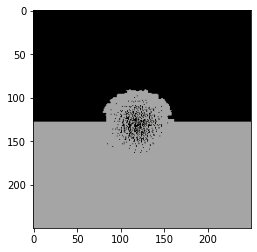

In [71]:
plt.imshow(i_obj.image.astype('uint8'))